In [337]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import scipy.stats as stats
import matplotlib.pyplot as plt
from uszipcode import SearchEngine
import folium

df = pd.read_csv("nyc_crashes_202301.csv")

----------------------------------------------------------------------------------------------------------------------------------------------
1. Construct a contigency table for missing in geocode (latitude and longitude) by borough. Is the missing pattern the same across borough? Formulate a hypothesis and test it.

In [338]:
for column in ["LATITUDE", "LONGITUDE"]:
    table = pd.crosstab(index=df["BOROUGH"], columns=df[column].isna())
    missing_by_borough = table.sum(axis=1)
    
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"For {column}:")
    print(f"Chi-squared test statistic: {chi2}")
    print(f"p-value: {p}")
    print(f"Degrees of freedom: {dof}")
    print(f"Expected frequencies:\n{expected}")
    
    missing_proportions = table.divide(missing_by_borough, axis=0)
    print(f"Missing proportions for {column}:\n{missing_proportions}")
    print("\n")

For LATITUDE:
Chi-squared test statistic: 7.472519360010264
p-value: 0.11292719580246866
Degrees of freedom: 4
Expected frequencies:
[[ 733.23697327    9.76302673]
 [1536.54100589   20.45899411]
 [ 711.52605347    9.47394653]
 [1193.11372904   15.88627096]
 [ 181.58223833    2.41776167]]
Missing proportions for LATITUDE:
LATITUDE          False      True
BOROUGH                          
BRONX          0.983849  0.016151
BROOKLYN       0.992293  0.007707
MANHATTAN      0.979196  0.020804
QUEENS         0.986766  0.013234
STATEN ISLAND  0.983696  0.016304


For LONGITUDE:
Chi-squared test statistic: 7.472519360010264
p-value: 0.11292719580246866
Degrees of freedom: 4
Expected frequencies:
[[ 733.23697327    9.76302673]
 [1536.54100589   20.45899411]
 [ 711.52605347    9.47394653]
 [1193.11372904   15.88627096]
 [ 181.58223833    2.41776167]]
Missing proportions for LONGITUDE:
LONGITUDE         False      True
BOROUGH                          
BRONX          0.983849  0.016151
BROOKLYN  

----------------------------------------------------------------------------------------------------------------------------------------------
2. Construct a hour variable with integer values from 0 to 23. Plot the histogram of the number of crashes by hour. Plot it by borough.

In [339]:
# used data cleaning process from hw3

# replaces the value 0.000000 with missing value
df["LONGITUDE"].replace(0.000000, np.nan, inplace=True)
df["LATITUDE"].replace(0.000000, np.nan, inplace=True)

# create a binary missingness indicator for "ZIP CODE" and "BOROUGH"
# 1 is missing 0 is not missing
df['ZIP CODE Missing'] = df['ZIP CODE'].isna().astype(int)
df['BOROUGH Missing'] = df['BOROUGH'].isna().astype(int)

# create a cross table of the missing patterns of "ZIP CODE" and "BOROUGH"
pd.crosstab(df['ZIP CODE Missing'], df['BOROUGH Missing'])

# create a cross table of the missing patterns of "ZIP CODE" and "BOROUGH"
ct = pd.crosstab(df['ZIP CODE Missing'], df['BOROUGH Missing'])

# used same function from STAT3255 notes
sr = SearchEngine()

def nyczip2burough(zip):
    nzip = int(zip)
    if nzip >= 10001 and nzip <= 10282:
        return "MANHATTAN"
    elif nzip >= 10301 and nzip <= 10314:
        return "STATEN ISLAND"
    elif nzip >= 10451 and nzip <= 10475:
        return "BRONX"
    elif nzip >= 11004 and nzip <= 11109:
        return "QUEENS"
    elif nzip >= 11351 and nzip <= 11697:
        return "QUEENS"
    elif nzip >= 11201 and nzip <= 11256:
        return "BROOKLYN"
    else:
        return np.nan
    
# loop through each row in the dataframe
for index, row in df.iterrows():
    
    # check if either ZIP CODE or BOROUGH is missing
    if pd.isnull(row["ZIP CODE"]) or pd.isnull(row["BOROUGH"]):
        
        # check if both LATITUDE and LONGITUDE are available
        if not pd.isnull(row["LATITUDE"]) and not pd.isnull(row["LONGITUDE"]):
            
            # use reverse geocoding to get the zip code and borough
            result = sr.by_coordinates(row["LATITUDE"], row["LONGITUDE"], radius=1, returns=1)
            
            # check if the result is not empty
            if result:
                
                # get the zip code and borough
                zipcode = result[0].zipcode
                borough = nyczip2burough(zipcode)
                
                # update the missing ZIP CODE and BOROUGH in the dataframe
                df.at[index, "ZIP CODE"] = zipcode
                df.at[index, "BOROUGH"] = borough

# convert lower cases to uppercases
df["CONTRIBUTING FACTOR VEHICLE 1"] = df["CONTRIBUTING FACTOR VEHICLE 1"].str.upper()

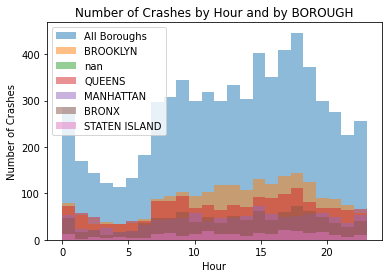

In [340]:
# create the hour variable
df["CRASH TIME"] = df["CRASH TIME"].astype(str)
df["hour"] = df["CRASH TIME"].str.split(":").str[0].astype(int)
df["minute"] = df["CRASH TIME"].str.split(":").str[1].astype(int)

df["hour"] = df.apply(lambda x: x["hour"] + 1 if x["minute"] >= 30 else x["hour"], axis=1)
df["hour"] = df["hour"].apply(lambda x: 0 if x == 24 else x)

# plot the histogram of the number of crashes by hour
plt.hist(df["hour"], bins=24, alpha=0.5, label="All Boroughs")

# plot the histogram of the number of crashes by hour and by BOROUGH
boroughs = df["BOROUGH"].unique()
for borough in boroughs:
    borough_df = df[df["BOROUGH"] == borough]
    plt.hist(borough_df["hour"], bins=24, alpha=0.5, label=borough)
    
plt.legend()
plt.xlabel("Hour")
plt.ylabel("Number of Crashes")
plt.title("Number of Crashes by Hour and by BOROUGH")
plt.show()


----------------------------------------------------------------------------------------------------------------------------------------------
3. Overlay the locations of the crashes on a map of NYC. The map could be a static map or Google map.

In [341]:
df.dropna(subset=["LATITUDE", "LONGITUDE", "BOROUGH"], inplace=True)

nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12)

# Define color for each borough
colors = {'MANHATTAN': 'red', 'BRONX': 'blue', 'BROOKLYN': 'green',
          'QUEENS': 'purple', 'STATEN ISLAND': 'orange'}

# Add markers for each crash to the map
for i, row in df.iterrows():
    borough = row["BOROUGH"]
    if borough in colors:
        folium.CircleMarker(location=[row["LATITUDE"], row["LONGITUDE"]],
                            radius=5, color=colors[borough], fill=True).add_to(nyc_map)

# Display the map
nyc_map.save("nyc_crash_map.html")

In [342]:
df["injury"] = df["NUMBER OF PERSONS INJURED"].apply(lambda x: 1 if x >= 1 else 0)

ct = pd.crosstab(df["injury"], df["BOROUGH"])
ct

BOROUGH,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
injury,,,,,
0,609,1232,672,991,173
1,366,846,358,669,92


In [343]:
chi2, p, dof, expected = stats.chi2_contingency(ct)
print("Chi-squared test statistic:", chi2)
print("p-value:", p)

Chi-squared test statistic: 14.378811566793468
p-value: 0.0061792125045281605


----------------------------------------------------------------------------------------------------------------------------------------------
5. Merge the crash data with the zip code database.

In [344]:
# create a dataframe of zip code information

from uszipcode import SearchEngine
import pandas as pd

sr = SearchEngine()

borough_zipcodes = {
    'Bronx': ['10453', '10457', '10460', '10458', '10467', '10468', '10451', '10452', '10456', '10454', '10455', '10459', '10474'],
    'Brooklyn': ['11212', '11213', '11216', '11233', '11238', '11209', '11214', '11228', '11204', '11218', '11219', '11230', '11234', '11236', '11239', '11223', '11224', '11229', '11235', '11201', '11205', '11215', '11217', '11231', '11203', '11210', '11225', '11226', '11207', '11208', '11211', '11222', '11220', '11232', '11206', '11221', '11237'],
    'Manhattan': ['10026', '10027', '10030', '10037', '10039', '10001', '10011', '10018', '10019', '10020', '10036', '10029', '10035', '10010', '10016', '10017', '10022', '10012', '10013', '10014', '10004', '10005', '10006', '10007', '10038', '10280', '10002', '10003', '10009', '10021', '10028', '10044', '10065', '10075', '10128', '10023', '10024', '10025'],
    'Queens': ['11004', '11101', '11102', '11103', '11104', '11105', '11106', '11351', '11354', '11355', '11356', '11357', '11358', '11359', '11360', '11361', '11362', '11363', '11364', '11365', '11366', '11367', '11412', '11423', '11432', '11433', '11434', '11435', '11436', '11109', '11369', '11370', '11372', '11373', '11377', '11378', '11379', '11385'],
    'Staten Island': ['10302', '10303', '10310', '10306', '10307', '10308', '10309', '10312', '10301', '10304', '10305', '10314']
}

zip_info_list = []

for borough, zipcodes in borough_zipcodes.items():
    for zipcode in zipcodes:
        zip_info = sr.by_zipcode(zipcode).__dict__
        zip_info['borough'] = borough
        zip_info_list.append(zip_info)

df1 = pd.DataFrame(zip_info_list)

df1.to_csv('zip_codes.csv')

In [345]:
# load into as new dataframe
zip_code_df = pd.read_csv("zip_codes.csv")
zip_code_df.shape

(138, 27)

In [346]:
# covert type to integer so that they are the same in both dataframes and merge based on zip code
df['ZIP CODE'] = df['ZIP CODE'].astype('int64')
merged_df = pd.merge(df, zip_code_df, left_on='ZIP CODE', right_on='zipcode', how='inner')

In [347]:
merged_df.head()

,CRASH DATE,CRASH TIME,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,LOCATION,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,...,area_code_list,common_city_list,population,median_home_value,county,population_density,median_household_income,state,bounds_west,borough
0,01/02/2023,18:00,BROOKLYN,11239,40.654440,-73.890810,"(40.65444, -73.89081)",WORTMAN AVENUE,NaN,NaN,...,212,['Brooklyn'],13393.0,354600.0,Kings County,23470.0,26275.0,NY,-73.891252,Brooklyn
1,01/02/2023,17:20,BROOKLYN,11239,40.652890,-73.866745,"(40.65289, -73.866745)",ERSKINE STREET,GATEWAY DRIVE,NaN,...,212,['Brooklyn'],13393.0,354600.0,Kings County,23470.0,26275.0,NY,-73.891252,Brooklyn
2,01/02/2023,16:45,BROOKLYN,11239,40.651863,-73.865360,"(40.651863, -73.86536)",BELT PARKWAY,NaN,NaN,...,212,['Brooklyn'],13393.0,354600.0,Kings County,23470.0,26275.0,NY,-73.891252,Brooklyn
3,01/02/2023,10:50,BROOKLYN,11239,40.675133,-73.879425,"(40.675133, -73.879425)",NaN,NaN,339 GATEWAY DRIVE,...,212,['Brooklyn'],13393.0,354600.0,Kings County,23470.0,26275.0,NY,-73.891252,Brooklyn
4,01/03/2023,15:00,BROOKLYN,11239,40.645073,-73.878654,"(40.645073, -73.878654)",NaN,NaN,1515 PENNSYLVANIA AVENUE,...,212,['Brooklyn'],13393.0,354600.0,Kings County,23470.0,26275.0,NY,-73.891252,Brooklyn


5. Fit a logistic model with injury as the outcome variable and covariates that are available in the data or can be engineered from the data. For example, zip code level covariates can be obtained by merging with the zip code database.

In [348]:
# engineering covariates

# convert date_of_crash to datetime
merged_df['CRASH DATE'] = pd.to_datetime(merged_df['CRASH DATE'], format='%m/%d/%Y')
# extract the timestamp as a numerical value
merged_df['CRASH DATE'] = merged_df['CRASH DATE'].astype(int)


# define columns to replace nan values
cols_to_replace_nan = ['CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
                       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1', 
                       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']

# replace nan values with "Unspecified"
for col in cols_to_replace_nan:
    merged_df[col] = merged_df[col].fillna("Unspecified")

from sklearn.preprocessing import LabelEncoder
# define columns to be label encoded
cols_to_encode = ['BOROUGH', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME', 'county', 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
                       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5', 'VEHICLE TYPE CODE 1', 
                       'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5']
# instantiate LabelEncoder object
le = LabelEncoder()
# loop through columns and apply label encoding
for col in cols_to_encode:
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))

# define columns with missing values
cols_with_missing = ['land_area_in_sqmi', 'water_area_in_sqmi', 'housing_units', 'occupied_housing_units', 'population',
                     'median_home_value', 'population_density', 'median_household_income']
# drop rows with missing values in specified columns
merged_df = merged_df.dropna(subset=cols_with_missing)

In [349]:
# check all column names in the merged dataframe
merged_df_columns = merged_df.columns.to_numpy()
print(merged_df_columns)

['CRASH DATE' 'CRASH TIME' 'BOROUGH' 'ZIP CODE' 'LATITUDE' 'LONGITUDE'
 'LOCATION' 'ON STREET NAME' 'CROSS STREET NAME' 'OFF STREET NAME'
 'NUMBER OF PERSONS INJURED' 'NUMBER OF PERSONS KILLED'
 'NUMBER OF PEDESTRIANS INJURED' 'NUMBER OF PEDESTRIANS KILLED'
 'NUMBER OF CYCLIST INJURED' 'NUMBER OF CYCLIST KILLED'
 'NUMBER OF MOTORIST INJURED' 'NUMBER OF MOTORIST KILLED'
 'CONTRIBUTING FACTOR VEHICLE 1' 'CONTRIBUTING FACTOR VEHICLE 2'
 'CONTRIBUTING FACTOR VEHICLE 3' 'CONTRIBUTING FACTOR VEHICLE 4'
 'CONTRIBUTING FACTOR VEHICLE 5' 'COLLISION_ID' 'VEHICLE TYPE CODE 1'
 'VEHICLE TYPE CODE 2' 'VEHICLE TYPE CODE 3' 'VEHICLE TYPE CODE 4'
 'VEHICLE TYPE CODE 5' 'ZIP CODE Missing' 'BOROUGH Missing' 'hour'
 'minute' 'injury' 'Unnamed: 0' '_sa_instance_state' 'lat'
 'land_area_in_sqmi' 'bounds_east' 'zipcode_type' 'lng'
 'water_area_in_sqmi' 'bounds_north' 'zipcode' 'timezone' 'housing_units'
 'bounds_south' 'major_city' 'radius_in_miles' 'occupied_housing_units'
 'post_office_city' 'area_code_li

In [350]:
# Define the predictor variables (covariates)
predictor_vars = ['CRASH DATE', 'BOROUGH', 'ZIP CODE', 'LATITUDE', 'LONGITUDE', 'ON STREET NAME', 'CROSS STREET NAME', 'OFF STREET NAME',
 'NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED',
 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED',
 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED',
 'CONTRIBUTING FACTOR VEHICLE 1', 'CONTRIBUTING FACTOR VEHICLE 2',
 'CONTRIBUTING FACTOR VEHICLE 3', 'CONTRIBUTING FACTOR VEHICLE 4',
 'CONTRIBUTING FACTOR VEHICLE 5', 'COLLISION_ID', 'VEHICLE TYPE CODE 1',
 'VEHICLE TYPE CODE 2', 'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4',
 'VEHICLE TYPE CODE 5', 'hour', 'minute', 'land_area_in_sqmi',
 'water_area_in_sqmi', 'housing_units',
 'radius_in_miles', 'occupied_housing_units', 'population',
 'median_home_value', 'county', 'population_density',
 'median_household_income']

merged_df[predictor_vars].head()

,CRASH DATE,BOROUGH,ZIP CODE,LATITUDE,LONGITUDE,ON STREET NAME,CROSS STREET NAME,OFF STREET NAME,NUMBER OF PERSONS INJURED,NUMBER OF PERSONS KILLED,...,land_area_in_sqmi,water_area_in_sqmi,housing_units,radius_in_miles,occupied_housing_units,population,median_home_value,county,population_density,median_household_income
0,1672617600000000000,1,11239,40.654440,-73.890810,1134,1102,1307,0,0,...,0.57,0.01,6335.0,1.0,6280.0,13393.0,354600.0,1,23470.0,26275.0
1,1672617600000000000,1,11239,40.652890,-73.866745,593,625,1307,0,0,...,0.57,0.01,6335.0,1.0,6280.0,13393.0,354600.0,1,23470.0,26275.0
2,1672617600000000000,1,11239,40.651863,-73.865360,307,1102,1307,8,0,...,0.57,0.01,6335.0,1.0,6280.0,13393.0,354600.0,1,23470.0,26275.0
3,1672617600000000000,1,11239,40.675133,-73.879425,1139,1102,724,1,0,...,0.57,0.01,6335.0,1.0,6280.0,13393.0,354600.0,1,23470.0,26275.0
4,1672704000000000000,1,11239,40.645073,-73.878654,1139,1102,227,1,0,...,0.57,0.01,6335.0,1.0,6280.0,13393.0,354600.0,1,23470.0,26275.0


In [351]:
from sklearn.linear_model import LogisticRegression

# create a new dataframe with only the predictor variables and the outcome variable
X = merged_df[predictor_vars]
y = merged_df['injury']

# create a logistic regression model
logreg = LogisticRegression()

# fit the model
logreg.fit(X, y)

LogisticRegression()

In [352]:
# get the intercept of the model
print(logreg.intercept_)

# get the predicted probabilities of the outcomes
print(logreg.predict_proba(X))

# Get the accuracy of the model
print(logreg.score(X, y))


[-1.60656404e-37]
[[0.61059339 0.38940661]
 [0.61059339 0.38940661]
 [0.61059339 0.38940661]
 ...
 [0.61067626 0.38932374]
 [0.61071493 0.38928507]
 [0.61072597 0.38927403]]
0.6106727574750831
